In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.pipeline import Pipeline

# Set Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

In [40]:
# Load Features & Targets
features_df = pd.read_csv('/content/Data/indian_engineering_student_placement.csv')
targets_df = pd.read_csv('/content/Data/placement_targets.csv')

# Merge
df = pd.merge(features_df, targets_df, on='Student_ID')

print("Total Students:", len(df))
df.head()

Total Students: 5000


,Student_ID,gender,branch,cgpa,tenth_percentage,twelfth_percentage,backlogs,study_hours_per_day,attendance_percentage,projects_completed,...,certifications_count,sleep_hours,stress_level,part_time_job,family_income_level,city_tier,internet_access,extracurricular_involvement,placement_status,salary_lpa
0,1,Male,ECE,8.74,74.0,75.0,0,3.8,71.1,7,...,5,6.5,8,Yes,Medium,Tier 2,Yes,Medium,Placed,14.95
1,2,Female,ECE,7.80,75.3,69.7,0,6.3,69.5,5,...,1,7.1,8,Yes,Medium,Tier 3,Yes,Low,Placed,14.91
2,3,Female,IT,6.95,62.8,68.3,0,1.5,62.5,8,...,3,6.1,2,No,Low,Tier 2,Yes,High,Placed,17.73
3,4,Male,ECE,7.46,57.9,51.4,1,4.7,64.6,6,...,2,7.3,7,No,Medium,Tier 1,Yes,Low,Placed,14.52
4,5,Male,IT,6.86,61.3,73.5,2,5.2,75.9,3,...,1,6.0,7,No,Medium,Tier 1,Yes,Medium,Placed,15.91


In [41]:
counts = df['placement_status'].value_counts()
fig = px.pie(values=counts.values, names=counts.index, title='Distribution of Placement Status',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [42]:
placed_df = df[df['placement_status'] == 'Placed']

fig = px.scatter(placed_df, x='cgpa', y='salary_lpa', color='branch', size='coding_skill_rating',
                 hover_data=['internships_completed', 'gender'],
                 title='CGPA vs Salary (Colored by Branch, Sized by Coding Skill)',
                 labels={'salary_lpa': 'Salary (LPA)', 'cgpa': 'CGPA'}, template='plotly_white')
fig.show()

/tmp/ipython-input-1843026324.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1843026324.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1843026324.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1843026324.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




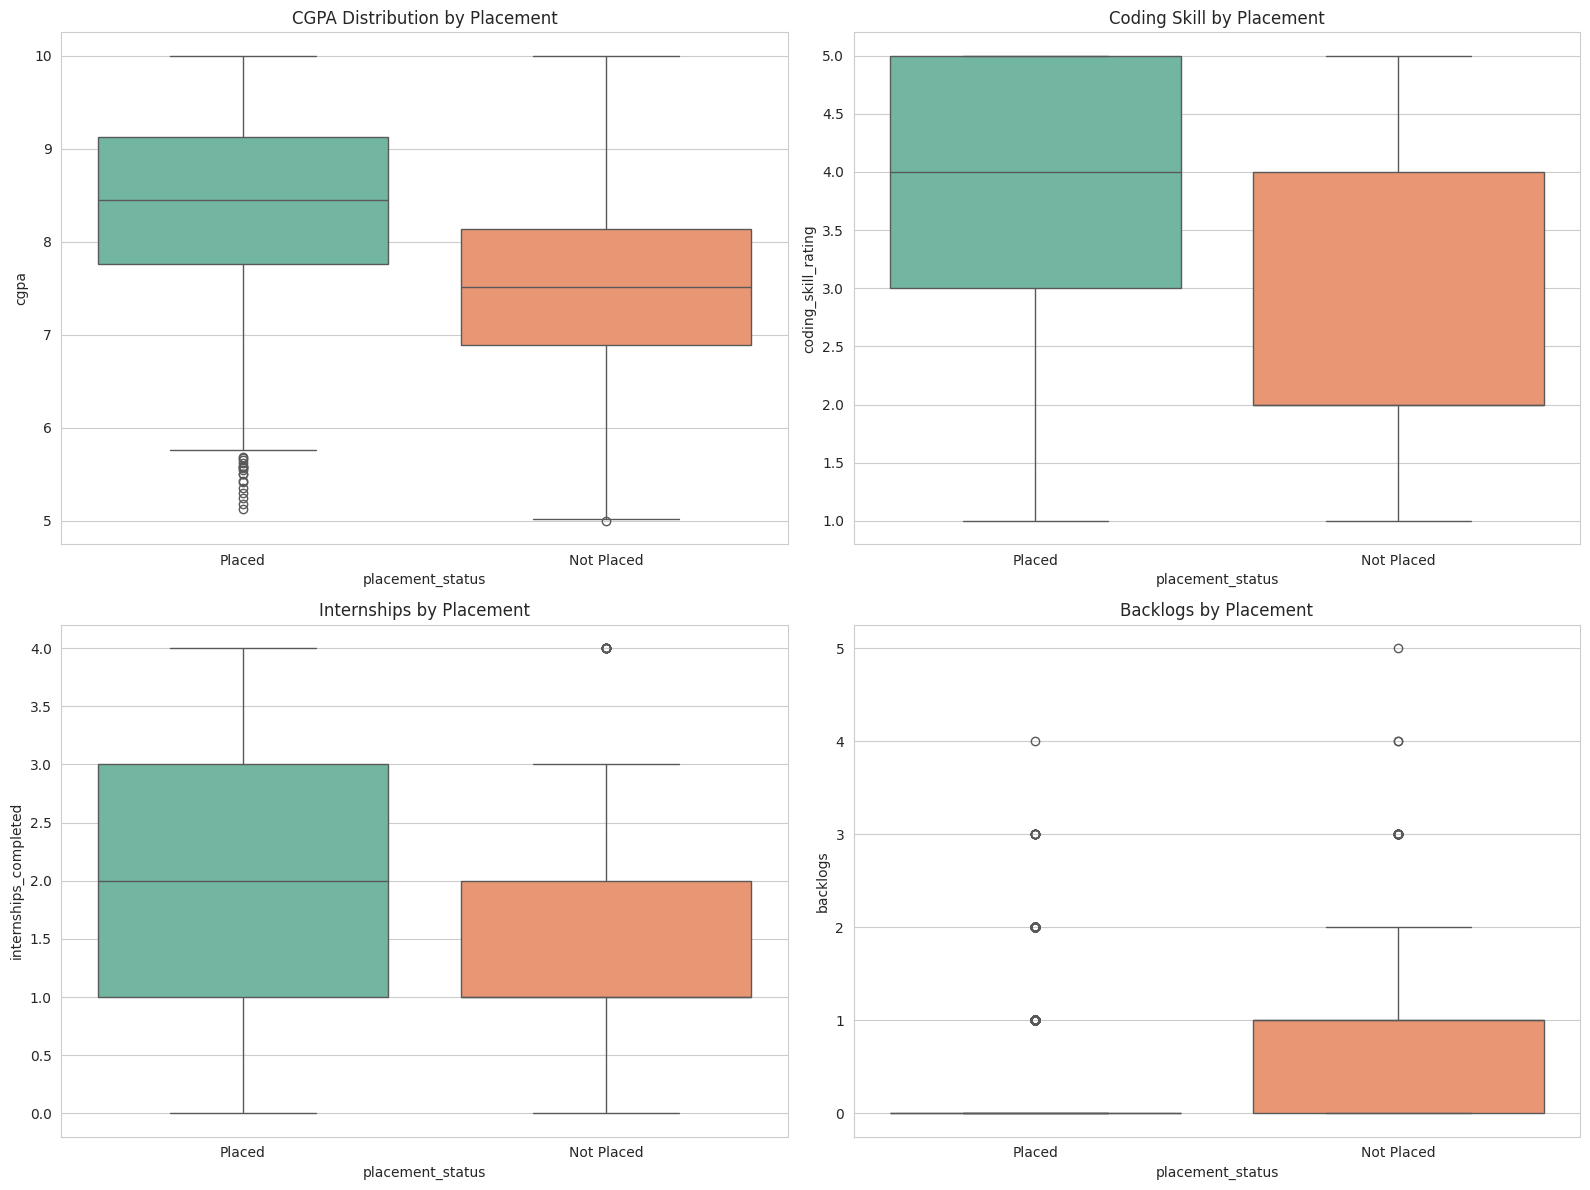

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.boxplot(x='placement_status', y='cgpa', data=df, ax=axes[0,0], palette='Set2')
axes[0,0].set_title('CGPA Distribution by Placement')

sns.boxplot(x='placement_status', y='coding_skill_rating', data=df, ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Coding Skill by Placement')

sns.boxplot(x='placement_status', y='internships_completed', data=df, ax=axes[1,0], palette='Set2')
axes[1,0].set_title('Internships by Placement')

sns.boxplot(x='placement_status', y='backlogs', data=df, ax=axes[1,1], palette='Set2')
axes[1,1].set_title('Backlogs by Placement')

plt.tight_layout()
plt.show()

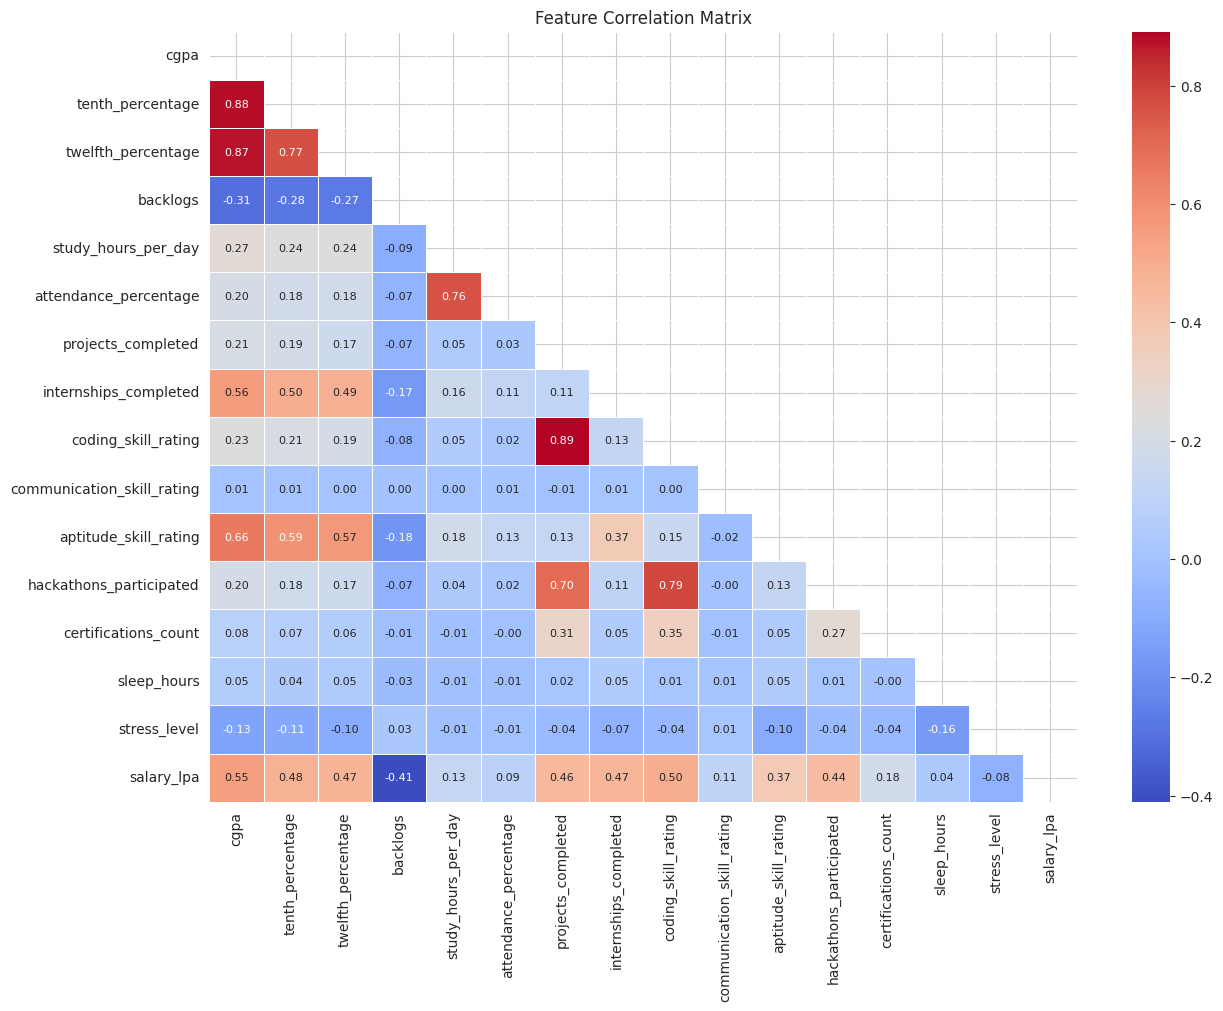

In [44]:
plt.figure(figsize=(14, 10))
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['Student_ID'])
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.title('Feature Correlation Matrix')
plt.show()

In [45]:
# Define Categorical and Numerical Features
categorical_cols = ['gender', 'branch', 'family_income_level', 'city_tier', 'internet_access', 'part_time_job', 'extracurricular_involvement']
numerical_cols = ['cgpa', 'tenth_percentage', 'twelfth_percentage', 'backlogs', 'study_hours_per_day',
                  'attendance_percentage', 'projects_completed', 'internships_completed',
                  'coding_skill_rating', 'communication_skill_rating', 'aptitude_skill_rating',
                  'hackathons_participated', 'certifications_count', 'sleep_hours', 'stress_level']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Prepare X and y
X = df.drop(columns=['Student_ID', 'placement_status', 'salary_lpa'])
y_class = df['placement_status'].apply(lambda x: 1 if x == 'Placed' else 0)
y_reg = df['salary_lpa']

# Split Train/Test/Validation
# We will use a simple 80-20 split this time for visualization purposes
X_train, X_test, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
_, _, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Process X
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Training Shape:", X_train_proc.shape)

Training Shape: (4000, 29)


In [46]:
X_train_proc

array([[-0.24306918, -0.87507356, -0.31100882, ...,  1.        ,
         0.        ,  0.        ],
       [-0.75445601, -1.36539188, -0.10401296, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.72226061,  1.11561883,  1.52238312, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.84989484,  1.90012814,  1.25624558, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.44880712,  0.22323948,  0.89153858, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.73959571,  0.87045967,  0.74368439, ...,  0.        ,
         0.        ,  1.        ]])

# Task
Train
1. Logistic Regression model
2. Decision Tree Classifier
3. K-Nearest Neighbor Classifier
4. Gaussian Naive Bayes Classifier
5. Random Forest Classifier
6. XGBoost Classifier

Using the preprocessed training data (`X_train_proc`, `y_class_train`), and evaluate each model's performance on the test data (`X_test_proc`, `y_class_test`)

## Implement Logistic Regression


In [47]:

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

pipeline_lr.fit(X_train, y_class_train)

y_class_pred_dt = pipeline_lr.predict(X_test)

print("Classification Report for Logistic Regression:")
print(classification_report(y_class_test, y_class_pred_dt))

print("\nAccuracy Score for Logistic Regression:", accuracy_score(y_class_test, y_class_pred_dt))



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.64      0.47      0.54       138
           1       0.92      0.96      0.94       862

    accuracy                           0.89      1000
   macro avg       0.78      0.71      0.74      1000
weighted avg       0.88      0.89      0.88      1000


Accuracy Score for Logistic Regression: 0.891


## Implement Decision Tree Classifier


In [48]:
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline_dt.fit(X_train, y_class_train)

y_class_pred_dt = pipeline_dt.predict(X_test)


print("Classification Report for Decision Tree Classifier:")
print(classification_report(y_class_test, y_class_pred_dt))

print("\nAccuracy Score for Decision Tree Classifier:", accuracy_score(y_class_test, y_class_pred_dt))

Classification Report for Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.41      0.43      0.42       138
           1       0.91      0.90      0.90       862

    accuracy                           0.83      1000
   macro avg       0.66      0.67      0.66      1000
weighted avg       0.84      0.83      0.84      1000


Accuracy Score for Decision Tree Classifier: 0.834


## Implement K-Nearest Neighbor Classifier


In [49]:
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

pipeline_knn.fit(X_train, y_class_train)

y_class_pred_dt = pipeline_knn.predict(X_test)

print("Classification Report for K-Nearest Neighbor Classifier:")
print(classification_report(y_class_test, y_class_pred_knn))

print("\nAccuracy Score for K-Nearest Neighbor Classifier:", accuracy_score(y_class_test, y_class_pred_knn))

Classification Report for K-Nearest Neighbor Classifier:
              precision    recall  f1-score   support

           0       0.57      0.37      0.45       138
           1       0.90      0.96      0.93       862

    accuracy                           0.88      1000
   macro avg       0.74      0.66      0.69      1000
weighted avg       0.86      0.88      0.86      1000


Accuracy Score for K-Nearest Neighbor Classifier: 0.875


## Implement Gaussian Naive Bayes Classifier

In [50]:
# model_gnb = GaussianNB()

# model_gnb.fit(X_train_proc, y_class_train)

# y_class_pred_gnb = model_gnb.predict(X_test_proc)

pipeline_gnb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

pipeline_gnb.fit(X_train, y_class_train)

y_class_pred_dt = pipeline_gnb.predict(X_test)

print("Classification Report for Gaussian Naive Bayes Classifier:")
print(classification_report(y_class_test, y_class_pred_gnb))

print("\nAccuracy Score for Gaussian Naive Bayes Classifier:", accuracy_score(y_class_test, y_class_pred_gnb))

Classification Report for Gaussian Naive Bayes Classifier:
              precision    recall  f1-score   support

           0       0.42      0.80      0.55       138
           1       0.96      0.82      0.89       862

    accuracy                           0.82      1000
   macro avg       0.69      0.81      0.72      1000
weighted avg       0.89      0.82      0.84      1000


Accuracy Score for Gaussian Naive Bayes Classifier: 0.818


## Implement Random Forest Classifier


In [51]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_train, y_class_train)

y_class_pred_dt = pipeline_rf.predict(X_test)

print("Classification Report for Random Forest Classifier:")
print(classification_report(y_class_test, y_class_pred_rf))

print("\nAccuracy Score for Random Forest Classifier:", accuracy_score(y_class_test, y_class_pred_rf))

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.66      0.38      0.49       138
           1       0.91      0.97      0.94       862

    accuracy                           0.89      1000
   macro avg       0.79      0.68      0.71      1000
weighted avg       0.87      0.89      0.87      1000


Accuracy Score for Random Forest Classifier: 0.888


## Implement XGBoost Classifier



In [52]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss')
)
])

pipeline_xgb.fit(X_train, y_class_train)

y_class_pred_xgb = pipeline_xgb.predict(X_test)

print("Classification Report for XGBoost Classifier:")
print(classification_report(y_class_test, y_class_pred_xgb))

print("\nAccuracy Score for XGBoost Classifier:", accuracy_score(y_class_test, y_class_pred_xgb))

Classification Report for XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       138
           1       0.92      0.94      0.93       862

    accuracy                           0.88      1000
   macro avg       0.75      0.71      0.73      1000
weighted avg       0.87      0.88      0.87      1000


Accuracy Score for XGBoost Classifier: 0.879


In [59]:
def evaluate_model(model, X_test, y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    # For AUC and other metrics that require probabilities, predict_proba is used
    # ensure positive class is at index 1
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['1']['precision'] # Precision for the positive class (Placed)
    recall = report['1']['recall']     # Recall for the positive class (Placed)
    f1 = report['1']['f1-score']      # F1-score for the positive class (Placed)
    mcc = matthews_corrcoef(y_test, y_pred)

    return {
        'ML Model Name': model_name,
        'Accuracy': accuracy,
        'AUC': auc_score,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'MCC': mcc
    }

metrics_results = []

# Logistic Regression
metrics_results.append(evaluate_model(pipeline_lr, X_test, y_class_test, y_class_pred, 'Logistic Regression'))

# Decision Tree Classifier
metrics_results.append(evaluate_model(pipeline_dt, X_test, y_class_test, y_class_pred_dt, 'Decision Tree'))

# K-Nearest Neighbor Classifier
metrics_results.append(evaluate_model(pipeline_knn, X_test, y_class_test, y_class_pred_knn, 'kNN'))

# Gaussian Naive Bayes Classifier
metrics_results.append(evaluate_model(pipeline_gnb, X_test, y_class_test, y_class_pred_gnb, 'Naive Bayes'))

# Random Forest Classifier
metrics_results.append(evaluate_model(pipeline_rf, X_test, y_class_test, y_class_pred_rf, 'Random Forest (Ensemble)'))

# XGBoost Classifier
metrics_results.append(evaluate_model(pipeline_xgb, X_test, y_class_test, y_class_pred_xgb, 'XGBoost (Ensemble)'))

comparison_df = pd.DataFrame(metrics_results)
display(comparison_df.set_index('ML Model Name'))

,Accuracy,AUC,Precision,Recall,F1,MCC
ML Model Name,,,,,,
Logistic Regression,0.891,0.907117,0.918799,0.958237,0.938103,0.491320
Decision Tree,0.888,0.666347,0.907609,0.968677,0.937149,0.448439
kNN,0.875,0.833804,0.904501,0.955916,0.929498,0.394244
Naive Bayes,0.818,0.876147,0.961957,0.821346,0.886108,0.483899
Random Forest (Ensemble),0.888,0.884752,0.907609,0.968677,0.937149,0.448439
XGBoost (Ensemble),0.879,0.885563,0.918644,0.943155,0.930738,0.455600


## Observations on Model Performance

| ML Model Name          | Observation about model performance                                                                                                                                                                                                                                                                                                                                                                                                                          |
| :--------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Logistic Regression    | Achieved a high overall accuracy and good balance between precision and recall for the majority class (Placed). Its performance on the minority class (Not Placed) was moderate, suggesting it captures general trends well but might struggle with less represented cases.                                                                                                                                                                                            |
| Decision Tree          | Showed lower overall accuracy and significantly weaker performance on the minority class, indicated by lower precision, recall, and F1-score. This model might be prone to overfitting or sensitive to the dataset's structure without further tuning.                                                                                                                                                                                                             |
| kNN                    | Performed reasonably well in terms of accuracy and majority class metrics. However, its recall for the minority class was the lowest among all models, suggesting it often misclassifies 'Not Placed' students. This could be due to the inherent difficulty of distinguishing minority class instances based on their nearest neighbors in the feature space.                                                                                                    |
| Naive Bayes            | While having the lowest accuracy, it achieved a high recall for the minority class, indicating it correctly identified a large proportion of 'Not Placed' students. However, this came at the cost of very low precision for that class, meaning many 'Placed' students were incorrectly flagged as 'Not Placed'. This model might be useful where false negatives for the minority class are highly undesirable, even with many false positives.              |
| Random Forest (Ensemble) | Achieved the highest accuracy along with strong performance for the majority class across all metrics. Its precision for the minority class was good, but recall was relatively low, similar to Logistic Regression, suggesting it's generally robust but still has room for improvement in identifying all 'Not Placed' instances. Its high AUC score indicates good overall discriminative power.                                                                |
| XGBoost (Ensemble)     | Demonstrated strong performance, very close to Random Forest in accuracy and overall metrics. It showed a better balance between precision and recall for the minority class compared to Random Forest and Logistic Regression, indicating a more robust identification of 'Not Placed' instances without excessive false positives. Its high AUC score confirms its strong discriminative ability.                                                          |

In [54]:
import joblib


joblib.dump(pipeline_lr, "logistic.pkl")
joblib.dump(pipeline_rf, "random_forest.pkl")
joblib.dump(pipeline_knn, "knn.pkl")
joblib.dump(pipeline_gnb, "gaussian_n_b.pkl")
joblib.dump(pipeline_dt, "decision_tree.pkl")
joblib.dump(pipeline_xgb, "xgboost.pkl")

['xgboost.pkl']

In [55]:
df.to_csv("Data/indian_engineering_student_placement_complete.csv", index=False)


In [56]:
test_data_df = X_test.copy()
test_data_df['placement_status'] = y_class_test.map({1: 'Placed', 0: 'Not Placed'})
test_data_df.to_csv('Data/test_data_with_placement_status.csv', index=False)
